(dl/02-optim)=
# Optimization

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/ok-transformer/blob/master/docs/nb/dl/02-optim.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/ok-transformer?style=social)](https://github.com/particle1331/ok-transformer)

---

**Readings:**  [[CS182-lec4]](https://cs182sp21.github.io/static/slides/lec-4.pdf) [[UvA-Tutorial4]](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html)

## Introduction

Recall that we can visualize $\mathcal{L}_{\mathcal{D}}(\boldsymbol{\Theta})$ as a surface ({numref}`02-loss-surface`). 
This is also known as the **loss landscape**. Gradient descent finds the minimum by 
locally moving in the direction of greatest decrease in loss ({numref}`02-gradient-descent-1d`). The step size depends on
the learning rate that has to be tuned well: a too large value can result in overshooting
the minimum, while a too small learning rate can result in slow convergence or being stuck in a
local minimum. In this notebook, we will discuss situations where gradient descent works, 
situations where it works poorly, and ways we can improve it.

<br>

```{figure} ../../img/nn/02-loss-surface.png
---
name: 02-loss-surface
width: 60%
---
Loss surface for a model with two weights. Source: [[CS182-lec4]](https://cs182sp21.github.io/static/slides/lec-4.pdf)
```

```{figure} ../../img/nn/02-gradient-descent-1d.png
---
name: 02-gradient-descent-1d
width: 60%
---
Gradient descent in 1-dimension. 
Next step moves opposite to the direction of the slope. Moreover, step size is scaled
based on the magnitude of the slope. Source: [[CS182-lec4]](https://cs182sp21.github.io/static/slides/lec-4.pdf)
```

## Gradient descent demo

To experiment with GD algorithms, we create a template class. The template implements a method for zeroing out the gradients. 
The only method that needs to be changed is how to update parameters in `update_param` for specific algorithms.

In [1]:
import torch
import torch.nn as nn

class OptimizerTemplate:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            self.update_param(p)

    def update_param(self, p):
        raise NotImplementedError

Our first algorithm is GD which we discussed in the previous notebook:

In [2]:
class GD(OptimizerTemplate):
    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_delta = -self.lr * p.grad
        p.add_(p_delta) # In-place update => saves memory, does not create comp graph

We will test with the following synthetic loss surface (i.e. not generated with data):

In [3]:
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial4/Optimization_and_Initialization.html
def pathological_loss(w0, w1):
    l1 = torch.tanh(w0) ** 2 + 0.01 * torch.abs(w1)
    l2 = torch.sigmoid(w1)
    return l1 + l2

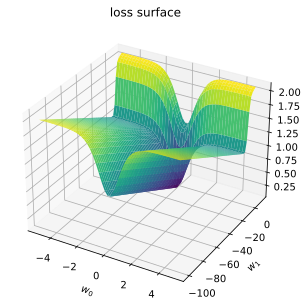

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from mpl_toolkits.mplot3d import Axes3D 
backend_inline.set_matplotlib_formats('svg')


def plot_surface(ax, f, title="", x_min=-5, x_max=5, y_min=-5, y_max=5, N=50):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(torch.tensor(X[i, j]), torch.tensor(Y[i, j]))
    
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')
    ax.set_title(title)
    

def plot_contourf(ax, f, w_hist, color, title="", x_min=-5, x_max=5, y_min=-5, y_max=5, N=50, **kw):
    x = np.linspace(x_min, x_max, N)
    y = np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(N):
        for j in range(N):
            Z[i, j] = f(torch.tensor(X[i, j]), torch.tensor(Y[i, j]))

    for t in range(1, len(w_hist)):
        ax.plot([w_hist[t-1][0], w_hist[t][0]], [w_hist[t-1][1], w_hist[t][1]], color=color)

    ax.contourf(X, Y, Z, levels=20, cmap='viridis')
    ax.scatter(w_hist[:, 0], w_hist[:, 1], marker='o', s=5, facecolors=color, color=color, **kw)
    ax.set_title(title)
    ax.set_xlabel(f'$w_0$')
    ax.set_ylabel(f'$w_1$')


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
plot_surface(ax, pathological_loss, x_min=-5, x_max=5, y_min=-100, y_max=10, title="loss surface")

The following optimization algorithm purely operates on the loss surface as a function of weights. 
It starts with initial weights `w_init`, then updates this weight iteratively by computing the
gradient of the loss function (which constructs a computational graph). The weight update step
depends on the particular optimizer class used.

In [5]:
def train_curve(optim, optim_params: dict, w_init=[5.0, 5.0], loss_fn=pathological_loss, num_steps=100):
    w = nn.Parameter(torch.FloatTensor(w_init), requires_grad=True)
    optim = optim([w], **optim_params)

    points = [torch.tensor([w[0], w[1], loss_fn(w[0], w[1])])]
    for _ in range(num_steps):
        optim.zero_grad()
        loss = loss_fn(w[0], w[1])
        loss.backward()
        optim.step()
        
        points.append(
            torch.cat([w.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0)
        )

    return torch.stack(points, dim=0).numpy()

Gradient descent from the same initial point with different learning rates:

In [6]:
def plot_gd_steps(ax, optim, optim_params: dict, label_map={}, w_init=[-2.5, 2.5], num_steps=300, **plot_kw):
    label = optim.__name__ + " (" + ", ".join(f"{label_map.get(k, k)}={v}" for k, v in optim_params.items()) + ")"
    path = train_curve(optim, optim_params, w_init=w_init, num_steps=num_steps)
    plot_contourf(ax[0], f=pathological_loss, w_hist=path, x_min=-10, x_max=10, y_min=-10, y_max=10, label=label, zorder=2, **plot_kw)
    ax[1].plot(np.array(path)[:, 2], label=label, color=plot_kw.get("color"), zorder=plot_kw.get("zorder", 1))
    ax[1].set_xlabel("steps")
    ax[1].set_ylabel("loss")
    ax[1].grid(linestyle="dotted", alpha=0.8)
    return path

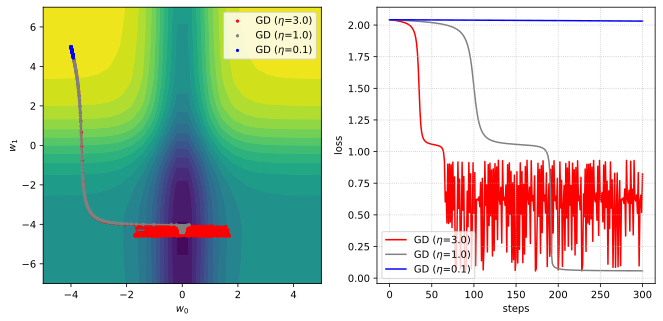

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, optim=GD, optim_params={"lr": 3.0}, w_init=[-4.0, 5.0], label_map={"lr": r"$\eta$"}, color="red")
plot_gd_steps(ax, optim=GD, optim_params={"lr": 1.0}, w_init=[-4.0, 5.0], label_map={"lr": r"$\eta$"}, color="gray")
plot_gd_steps(ax, optim=GD, optim_params={"lr": 0.1}, w_init=[-4.0, 5.0], label_map={"lr": r"$\eta$"}, color="blue")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[0].legend()
ax[1].legend();

The direction of steepest descent does not always point to the minimum. Depending on the learning rate, it can oscillate around a minimum, or it can get stuck in a flat region of the surface.

## Loss landscape

For convex functions, gradient descent has strong guarantees of converging. However, the loss surface of neural networks
are generally nonconvex. Clever dimensionality reduction techniques allow us to visualize loss function curvature despite the very large number of parameters ({numref}`02-visualizing-loss` from {cite}`visualizing_loss`). Notice that there are **plateaus** (or flat minimas) and **local minimas** which makes gradient descent hard. In high-dimension **saddle points** are the most common critical points.

<br>

```{figure} ../../img/nn/02-visualizing-loss.png
---
name: 02-visualizing-loss
width: 80%
---
The loss surfaces of ResNet-56 with (**right**) and without (**left**) skip connections. 
The loss surface on the right looks better although there are still some flatness. {cite}`visualizing_loss`
```

```{margin}
**Reading**: <br>
[Escaping from Saddle Points](https://www.offconvex.org/2016/03/22/saddlepoints/)
```

```{figure} ../../img/nn/02-optima-type.png
---
name: 02-optima-type
width: 100%
---
Types of critical points. Source: [[CS182-lec4]](https://cs182sp21.github.io/static/slides/lec-4.pdf)
```

### Local minima

Local minimas are very scary, in principle, since gradient descent could converge to a
solution that is arbitrarily worse than the global optimum. Surprisingly, this becomes 
less of an issue as the number of parameters increases. 
They exist, but tend to be not much worse than global optima ({numref}`02-local-minima`).
Here we see that for larger networks the variance between loss values of local optima become
smaller. In other words, local minima tend to be equivalent for large networks.

```{figure} ../../img/nn/02-local-minima.png
---
name: 02-local-minima
width: 80%
---
Test loss of 1000 networks on a scaled-down version of MNIST, where
each image was downsampled to size 10×10. The networks have one hidden layer
and with 25, 50, 100, 250, and 500 hidden units, 
each one starting from a random set of parameters sampled uniformly within the unit cube. 
All networks were trained for 200 epochs using SGD with
learning rate decay. Source: {cite}`pmlr-v38-choromanska15`
```

### Plateaus

Plateaus are regions in the loss landscape with small gradients. It can also be a flat local minima. Below the initial weights is in a plateau, and the optimizer with small learning rate gets stuck and fails to converge. Large learning rate allows the optimizer to escape such regions. So we cannot just choose small learning rate to prevent oscillations. We will see later that **momentum** helps to overcome this tradeoff.

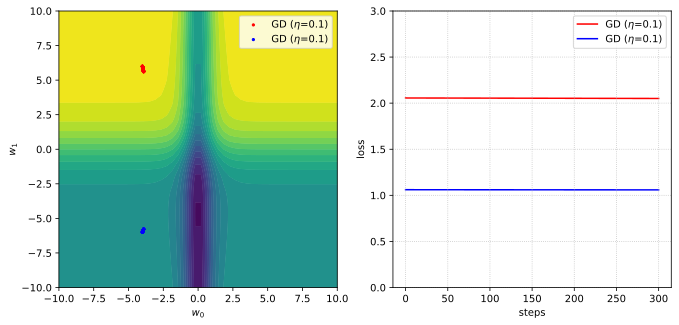

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, optim=GD, optim_params={"lr": 0.1}, w_init=[-4.0,  6.0], label_map={"lr": r"$\eta$"}, color="red")
plot_gd_steps(ax, optim=GD, optim_params={"lr": 0.1}, w_init=[-4.0, -6.0], label_map={"lr": r"$\eta$"}, color="blue")

ax[1].set_ylim(0, 3)
ax[0].legend()
ax[1].legend();

### Saddle points

```{margin}
**Reading:** <br>
[Escaping from Saddle Points](https://www.offconvex.org/2016/03/22/saddlepoints/)
```

Saddle points are critical points (i.e. gradient zero) that are local minimum in some dimensions but local maximum in other dimensions. Neural networks have a lot of symmetry which can result in exponentially many local minima. Saddle points naturally arise
in paths that connect these local minima ({numref}`02-connected-minima`). 
It takes a long time to escape a saddle point since it is usually surrounded by high-loss plateaus {cite}`dauphin2014`.
A saddle point looks like a special structure. But in high-dimension, it turns out that most optima are saddle points.

```{figure} ../../img/nn/02-connected-minima.png
---
name: 02-connected-minima
width: 60%
---
Paths between two minimas result in a saddle point. Source: [[offconvex.org]](https://www.offconvex.org/2016/03/22/saddlepoints/)
```

The Hessian $\boldsymbol{\mathsf{H}}$ at the critical point of a surface is a matrix containing second derivatives at that point. We will see shortly that these characterize the local curvature. From [Schwarz's theorem](https://en.wikipedia.org/wiki/Symmetry_of_second_derivatives#Schwarz's_theorem), mixed partials are equal assuming the second partial derivatives are continuous around the optima. It follows that $\boldsymbol{\mathsf{H}}$ is symmetric, and from the [Real Spectral Theorem](https://github.com/particle1331/computational-linear-algebra/blob/master/chapters/02-svd.ipynb), $\boldsymbol{\mathsf{H}}$ is diagonalizable with real eigenvalues. It turns out that local curvature is characterized by whether the eigenvalues are negative, zero, or positive.

If all eigenvalues of the Hessian are positive, it is [positive-definite](https://en.wikipedia.org/wiki/Definite_matrix), i.e. $\boldsymbol{\mathsf{x}}^\top \boldsymbol{\mathsf{H}}\, \boldsymbol{\mathsf{x}} > 0$ for $\boldsymbol{\mathsf{x}} \neq \boldsymbol{0}.$ This follows directly from the spectral decomposition $\boldsymbol{\mathsf{H}} = \boldsymbol{\mathsf{U}} \boldsymbol{\Lambda} \boldsymbol{\mathsf{U}}^\top$ such that $\boldsymbol{\Lambda}$ is the diagonal matrix of eigenvalues of $\boldsymbol{\mathsf{H}}$ and $\boldsymbol{\mathsf{U}}$ is an orthogonal matrix with corresponding unit eigenvectors as columns. This is the multivariable equivalent of **concave up**. On the other hand, if all eigenvalues of $\boldsymbol{\mathsf{H}}$ are negative, then it is negative-definite or **concave down**. To see this, observe that the Taylor expansion at the critical point is:

$$
\Delta \mathcal{L}_{\mathcal{D}} = \frac{1}{2} \Delta \boldsymbol{\Theta}^\top \boldsymbol{\mathsf{H}}\, \Delta \boldsymbol{\Theta} + O(\Delta \boldsymbol{\Theta}^3).
$$

If any eigenvalue is zero, more information is needed (i.e. we need third order terms). Finally, if the eigenvalues are mixed, we get a **saddle point** where there are orthogonal directions corresponding to eigenvectors where the loss decreases and directions where the loss increases. Getting $M = |\boldsymbol{\Theta}|$ eigenvalues of the same sign or having one zero eigenvalue is relatively rare for large networks with complex loss surfaces, so that the probability that the critical point is a saddle point is high.

## Momentum methods

### Momentum

Recall that high learning rate allows the optimizer to overcome plateaus. However, this can result in oscillation. The intuition behind **momentum** is that if successive gradient steps point in different
directions, we should cancel off the directions that disagree. Moreover, if successive gradient steps point in similar directions, we
should go faster in that direction. Simply adding gradients can result in extreme step size, so exponential averaging using a parameter $0 \leq \beta < 1$ is used:

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^t &= \beta \, \boldsymbol{\mathsf{m}}^{t-1} + (1 - \beta) \, \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \boldsymbol{\mathsf{m}}^{t}.
\end{aligned}
$$

Note that $\beta = 0$ is just regular GD.
In the following implementation, we add an extra parameter `momentum=0.0` to the `GD` class for $\beta$. Observe that the optimizer is now **stateful**: the attribute `self.m` stores the momentum vector $\boldsymbol{\mathsf{m}}^t$ above as a dictionary with parameter keys. We will set $\boldsymbol{\mathsf{m}}^0$ to be the zero vector. The indexing demands that $\boldsymbol{\Theta}^1 = \boldsymbol{\Theta}_{\text{init}}.$

```{margin}
Saving the `state_dict` for the optimizer and model in PyTorch allows to [resume training](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training).
```

In [9]:
class GD(OptimizerTemplate):
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.beta = momentum
        self.m = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.m[p] = self.beta * self.m[p] + (1 - self.beta) * p.grad
        p_delta = -self.lr * self.m[p]
        p.add_(p_delta)

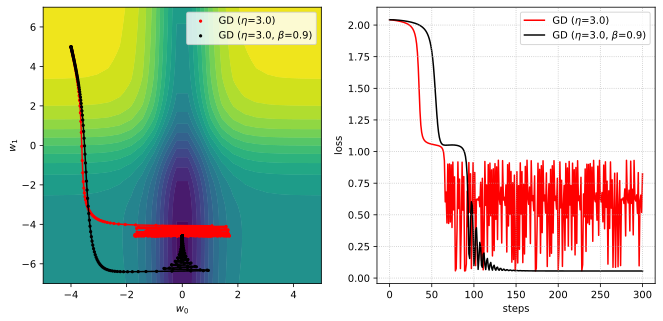

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
label_map_gdm = {"lr": r"$\eta$", "momentum": r"$\beta$"}
plot_gd_steps(ax, optim=GD, optim_params={"lr": 3.0},                  w_init=[-4.0, 5.0], label_map=label_map_gdm, color="red")
plot_gd_steps(ax, optim=GD, optim_params={"lr": 3.0, "momentum": 0.9}, w_init=[-4.0, 5.0], label_map=label_map_gdm, color="black")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

The optimizer is able to escape in initial plateau due to a high learning rate. 
Then, it overshoots resulting in delayed decrease in loss.
Between roughly 60-80 steps, the optimizer escapes the lower plateau
by accumulating small gradients toward the minimum.
Finally, it oscillates around the minimum but these eventually die down due to the effect of momentum.

**Remark.** Momentum is aptly named since $\beta$ can be thought of as the mass of a ball rolling down the surface to a minimum. It resists force (gradients), and maintains an inertia (momentum state vector) from previous updates.

### RMSProp

The relative magnitude of gradient is not very informative: only its **sign** is. 
Moreover, it changes during the course of training. Near the minimum it becomes small 
slowing down convergence. 
This makes it difficult to tune learning rate for different functions, or for different
points on the same function. To fix this, 
**RMSProp** normalizes the gradient along each dimension. 
It estimates the size of the gradient using exponential averaging with $\boldsymbol{\mathsf{v}}^0 = \mathbf{0}$:

$$
\begin{aligned}
\boldsymbol{\mathsf{v}}^t &= \beta \, \boldsymbol{\mathsf{v}}^{t-1} + (1 - \beta) \, \left( \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \right)^2 \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \frac{1}{\sqrt{\boldsymbol{\mathsf{v}}^{t}}} \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}).
\end{aligned}
$$

A similar algorithm called **AdaGrad** {cite}`adagrad` uses the update rule $\boldsymbol{\mathsf{v}}^t = \boldsymbol{\mathsf{v}}^{t-1} + \left( \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \right)^2.$ This simply adds the squared gradients which results in auto-tuning the learning rate near the minimum. This works for convex problems, where it has theoretical guarantees, since it avoids oscillation with large learning rate. 
But this only works if it finds the optimum quickly before the rate decays too much. RMSProp tends to be better for nonconvex problems.

In [11]:
class RMSProp(OptimizerTemplate):
    def __init__(self, params, lr, beta=0.9):
        super().__init__(params, lr)
        self.beta = beta
        self.v = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.v[p] = self.beta * self.v[p] + (1 - self.beta) * p.grad ** 2
        p_delta = -self.lr * p.grad / torch.sqrt(self.v[p])
        p.add_(p_delta)

Notice that gradient normalization allows escaping plateaus:

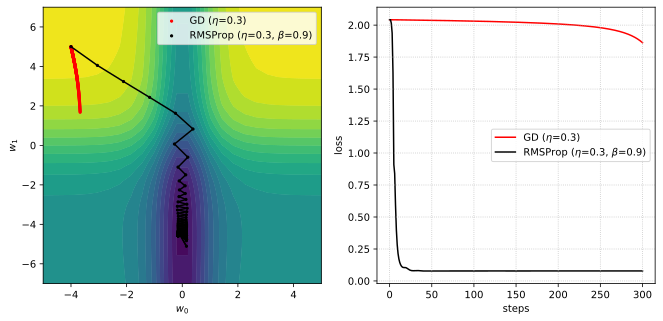

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
label_map_rmsprop = {"lr": r"$\eta$", "beta": r"$\beta$"}
plot_gd_steps(ax, optim=GD,      optim_params={"lr": 0.3},              w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="red")
plot_gd_steps(ax, optim=RMSProp, optim_params={"lr": 0.3, "beta": 0.9}, w_init=[-4.0, 5.0], label_map=label_map_rmsprop, color="black")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

### Adam

Notice that RMSProp experiences oscillations around the minimum. **Adam** {cite}`adam` fixes this by combining momentum with RMSProp. Adam also uses bias correction so that gradients dominate during early stages of training instead of the state vectors which are initially set to zero. Let $0 \leq \beta_1 < 1$, $0 \leq \beta_2 < 1$, and $0 < \epsilon \ll 1.$ Set $\boldsymbol{\mathsf{m}}^0 = \boldsymbol{\mathsf{v}}^0  = \mathbf{0}$ and $\boldsymbol{\Theta}^1 = \boldsymbol{\Theta}_{\text{init}}.$ Starting with $t = 1$:

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^t &= \beta_1 \, \boldsymbol{\mathsf{m}}^{t-1} + (1 - \beta_1) \, \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \\
\boldsymbol{\mathsf{v}}^t &= \beta_2 \, \boldsymbol{\mathsf{v}}^{t-1} + (1 - \beta_2) \, \left( \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}) \right)^2 \\
\hat{\boldsymbol{\mathsf{m}}}^t &= \frac{\boldsymbol{\mathsf{m}}^t}{1 - {\beta_1}^t} \\
\hat{\boldsymbol{\mathsf{v}}}^t &= \frac{\boldsymbol{\mathsf{v}}^t}{1 - {\beta_2}^t} \\
\boldsymbol{\boldsymbol{\Theta}}^{t+1} &= \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \, \frac{\hat{\boldsymbol{\mathsf{m}}}^t}{\sqrt{\hat{\boldsymbol{\mathsf{v}}}^{t}} + \epsilon}.
\end{aligned}
$$

A good set of parameters for Adam is $\eta = 0.001$, $\beta_1 = 0.9$, $\beta_2 = 0.999$ and $\epsilon = 10^{-8}.$ Note that we can now choose the same $\eta$ regardless of the loss function $f$ similar to RMSProp. Here we choose $\beta_2 > \beta_1$ since gradient magnitude usually does not change as fast as its direction so we choose a larger momentum.

**Remark.** To understand bias correction, let $\boldsymbol{\mathsf{g}}^t = \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}^{t}).$ Note that $t$ indexes the points such that $t = 1$ corresponds to the initial point where $\boldsymbol{\mathsf{g}}^1 = \nabla_{\boldsymbol{\Theta}}\, f(\boldsymbol{\Theta}_{\text{init}}).$ This also means that $t$ is the number of gradients that are summed when computing the exponential average. Observe that 

$$
\begin{aligned}
\boldsymbol{\mathsf{m}}^1
&= (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^1\\
\boldsymbol{\mathsf{m}}^2
&= \beta_1\, (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^1 + (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^2\\
&= (1 - \beta_1) \left({\beta_1}\,\boldsymbol{\mathsf{g}}^1 + \boldsymbol{\mathsf{g}}^2 \right).\\
\boldsymbol{\mathsf{m}}^3 
&= \beta_1\, (1 - \beta_1)\,(\beta_1  \, \boldsymbol{\mathsf{g}}^1 +  \, \boldsymbol{\mathsf{g}}^2) + (1 - \beta_1)\, \boldsymbol{\mathsf{g}}^3\\
&= (1 - \beta_1) \left({\beta_1}^2 \boldsymbol{\mathsf{g}}^1 + {\beta_1}\, \boldsymbol{\mathsf{g}}^2 + \boldsymbol{\mathsf{g}}^3 \right).\\
\end{aligned}
$$

This slows down training at early steps where the terms in the sum are few, so that $\boldsymbol{\mathsf{m}}^t$ is small. Recall that $(1 - {\beta_1}^{3}) = (1 - {\beta_1}) \sum_{t = 0}^2 {\beta_1}^t.$ Dividing with this gets us a proper average that is biased towards recent gradients:

$$
\begin{aligned}
\hat{\boldsymbol{\mathsf{m}}}^3 &= \frac{{\beta_1}^2 \boldsymbol{\mathsf{g}}^1 + {\beta_1}\, \boldsymbol{\mathsf{g}}^2 + \boldsymbol{\mathsf{g}}^3}{{\beta_1}^2 + {\beta_1} + 1}.\\
\end{aligned}
$$

This calculation extends inductively. For $t = 1$, $\boldsymbol{\mathsf{m}}^1 = (1 - \beta_1)\,\boldsymbol{\mathsf{g}}^1$ whereas with bias correction we get $\hat{\boldsymbol{\mathsf{m}}}^1 = \boldsymbol{\mathsf{g}}^1.$ The following implementation gets this right with `self.t[p] = 1` at the initial point. Note that bias correction in momentum only works because of the auto-learning rate tuning with $1 / \sqrt{\hat{\boldsymbol{\mathsf{v}}}^t}$. Otherwise, the optimizer rolls down a slope too fast, missing the minimum!

<br>

In [13]:
class Adam(OptimizerTemplate):
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = {p: torch.zeros_like(p.data) for p in self.params}
        self.v = {p: torch.zeros_like(p.data) for p in self.params}
        self.t = {p: 0 for p in self.params}    # Params are updated one by one.
        self.eps = eps

    def update_param(self, p):
        self.t[p] += 1
        self.m[p] = self.beta1 * self.m[p] + (1 - self.beta1) * p.grad
        self.v[p] = self.beta2 * self.v[p] + (1 - self.beta2) * p.grad ** 2
        m_hat = self.m[p] / (1 - self.beta1 ** self.t[p])
        v_hat = self.v[p] / (1 - self.beta2 ** self.t[p])
        p_delta = -self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)
        p.add_(p_delta)

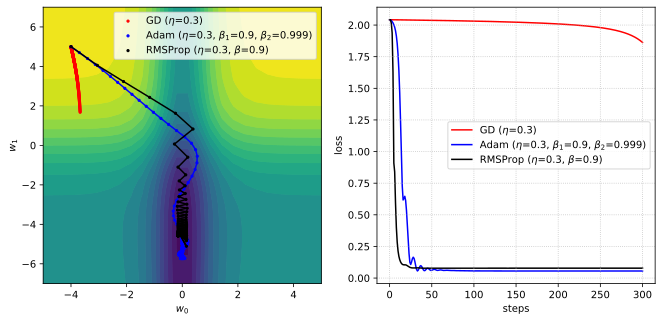

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
label_map_adam = {"lr": r"$\eta$", "beta1": r"$\beta_1$", "beta2": r"$\beta_2$"}
plot_gd_steps(ax, optim=GD,      optim_params={"lr": 0.3},                               w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="red")
plot_gd_steps(ax, optim=Adam,    optim_params={"lr": 0.3, "beta1": 0.9, "beta2": 0.999}, w_init=[-4.0, 5.0], label_map=label_map_adam,    color="blue")
plot_gd_steps(ax, optim=RMSProp, optim_params={"lr": 0.3, "beta": 0.9},                  w_init=[-4.0, 5.0], label_map=label_map_rmsprop, color="black")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

The effect of momentum can be seen by the dampening of oscillations. Also notice that Adam takes fixed step-size similar to RMSProp. Then auto-tuning kicks in to decrease the step size as the gradient decreases around the minimum.

Trying out a larger learning rate:

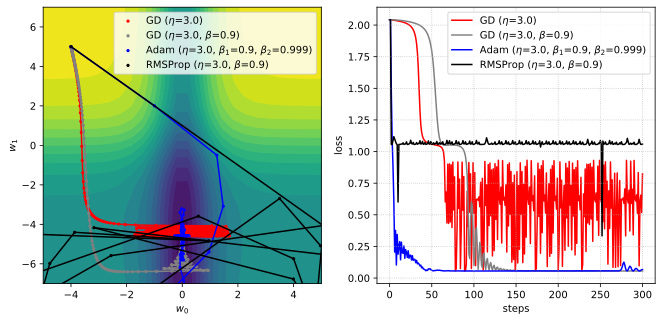

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, optim=GD,      optim_params={"lr": 3.0},                               w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="red")
plot_gd_steps(ax, optim=GD,      optim_params={"lr": 3.0, "momentum": 0.9},              w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="gray")
plot_gd_steps(ax, optim=Adam,    optim_params={"lr": 3.0, "beta1": 0.9, "beta2": 0.999}, w_init=[-4.0, 5.0], label_map=label_map_adam,    color="blue")
plot_gd_steps(ax, optim=RMSProp, optim_params={"lr": 3.0, "beta": 0.9},                  w_init=[-4.0, 5.0], label_map=label_map_rmsprop, color="black")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

RMSProp does not perform well with large learning rate as it worsens oscillation. Adam combines momentum with adaptive step-size making it converge fast. Notice that the loss with Adam increases a bit near the end of training. This can be attributed with the oscillations changing orientation (left). For the sake of argument, assuming updates in this direction is zero, then we get an effective step-size of $\eta.$ This does not happen with GD with momentum which seems to work better if tuned well and given enough time to converge. This is discussed further below.

**Remark.** Note that the gradient is coupled with the averaging technique in Adam. If we include regularization or weight decay in the loss, this means weight decay is likewise coupled. This is fixed in **AdamW** {cite}`adamw` which adjusts the weight decay term to appear in the gradient update:

$$
\boldsymbol{\boldsymbol{\Theta}}^{t+1} = \boldsymbol{\boldsymbol{\Theta}}^{t} 
- \eta \, 
\left( 
    \frac{\hat{\boldsymbol{\mathsf{m}}}^t}{\sqrt{\hat{\boldsymbol{\mathsf{v}}}^{t}} + \epsilon}
    + \lambda^t \,\boldsymbol{\Theta}
\right)
$$

where $\lambda^t$ is the weight decay term at time $t.$ See [AdamW implementation](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) in PyTorch.

## SGD

Gradient descent computes gradients for each instance in the training set.
This can be expensive for large datasets.
But recall that training loss is just an estimate of the true loss 
however large the sample $\mathcal{D}$ is.
Hence, we can take a random subset 
$\mathcal{B} \subset \mathcal{D}$ such that $B = |\mathcal{B}| \ll |\mathcal{D}|$
and still get an unbiased estimate $\mathcal{L}_{\mathcal{B}} \approx \mathcal{L}.$ 
This is called **Stochastic Gradient Descent** (SGD).
It turns out that this works just as well in practice as regular GD, but a lot cheaper computationally.
Moreover, SGD has been shown to escape saddle points with some theoretical guarantees {cite}`dauphin2014`.
SGD update rule:

$$
\boldsymbol{\Theta}^{t+1} = \boldsymbol{\Theta}^t - \eta\; \nabla_{\boldsymbol{\Theta}}\, \mathcal L_{\mathcal{B}}(\boldsymbol{\Theta}^t)
$$

Typically, we take $B = 8, 32, 64, 128, 256.$ Note that SGD is essentially GD above it just replaces the function $f$ at each step with $\mathcal{L}_{\mathcal{B}}.$ Hence, all modifications of GD discussed have the same update rule for SGD. 
The same results and observations also mostly hold. Although, now we have to reason with noisy approximations $f_t \approx f$ at each step unlike before where it is fixed.

**Remark.** From here, all previously discussed algorithms (Adam, etc.) will be assumed to be using stochastic mini-batch sampling like SGD. The following shows the loss surface approximation at each step.

In [16]:
from functools import partial

def loss(w0, w1, X, y):
    return ((X @ np.array([w0, w1]) - y)**2).mean()

def grad(w, X, y, B=None):
    """Gradient step for the MSE loss function"""
    dw = 2*((X @ w - y).reshape(-1, 1) * X).mean(axis=0)
    return dw / np.linalg.norm(dw)

def sgd(w0, X, y, eta=0.1, steps=10, B=32):
    """Return sequence of weights from GD."""
    w = np.zeros([steps, 2])
    w[0, :] = w0
    for j in range(1, steps):
        batch = torch.randint(0, len(X), size=(B,))
        u = w[j-1, :]
        w[j, :] = u - eta * grad(u, X[batch], y[batch])
    return w


# Generate data
B = 4
n = 1000
X = np.zeros((n, 2))
X[:, 1] = np.random.uniform(low=-1, high=1, size=n)
X[:, 0] = 1
w_min = np.array([-1, 3])
y = (X @ w_min) + 0.05 * np.random.randn(n)  # data: y = -1 + 3x + noise

# Gradient descent
w_init = [-4, -4]
w_step_gd  = sgd(w_init, X, y, eta=0.5, steps=30, B=len(X))
w_step_sgd = sgd(w_init, X, y, eta=0.5, steps=30, B=B)

# Create a figure and two subplots
fig = plt.figure(figsize=(12, 11))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

# Call the functions with the respective axes
plt.tight_layout()
plot_contourf(ax1, partial(loss, X=X, y=y), w_step_gd, color="red")
plot_contourf(ax2, partial(loss, X=X, y=y), w_step_sgd, color="red")
plot_surface(ax3, partial(loss, X=X, y=y), N=50)
for i in range(5):
    batch = torch.randint(0, len(X), size=(B,))
    plot_surface(ax4, f=partial(loss, X=X[batch], y=y[batch]), N=50)

ax1.set_title("GD")
ax2.set_title(f"SGD (B={B})")
ax3.set_title("\nloss surface")
ax4.set_title(f"\nloss approx. (B={B})")
fig.tight_layout()
plt.show()

<br>

**Remark.** Randomly sampling from $N \gg 1$ points at each step is expensive. Instead, we typically just shuffle the dataset once, then iterate over it with slices of size $B$. This is essentially sampling without replacement which turns out that this is more [data efficient](https://www.d2l.ai/chapter_optimization/sgd.html#stochastic-gradients-and-finite-samples) (i.e. the model gets to see more varied data). One such pass over the dataset is called an **epoch**. This is done for example when using PyTorch DataLoaders:

In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(torch.arange(10), batch_size=2, shuffle=True)

print("Epoch 1:")
[print(x) for x in train_loader]
print()
print("Epoch 2:")
[print(x) for x in train_loader];

Epoch 1:
tensor([5, 6])
tensor([4, 9])
tensor([0, 7])
tensor([1, 8])
tensor([3, 2])

Epoch 2:
tensor([1, 3])
tensor([7, 6])
tensor([2, 5])
tensor([0, 4])
tensor([9, 8])


## Hyperparameters

### Batch size

Setting powers of 2 for batch size $B = 16, 32, 64, ..., 512$ tends to generally work well.
Starting with $B = 32$ is recommended for image tasks {cite}`batch-size-32`.
Note that we may need to train with large batch sizes depending on the network architecture, the 
nature of the training distribution, or if we have large compute {cite}`imagenet1hour`.
Conversely, we are sometimes forced to use small batches due to resource constraints.

**Large batch.** Naively increasing $B$ can result in worse generalization ({numref}`02-large-batch-training`).
This has been attributed to large batch size decreasing gradient noise up to a certain threshold {cite}`learning-rate-function-of-batch-size`. 
The existence of a threshold may explain {numref}`02-imagenet-1-hour` in {cite}`imagenet1hour`
where the simple scaling rule breaks down.
To counteract this effect, {cite}`imagenet1hour` suggests scaling up the learning rate
by the same factor that we increase batch size ({numref}`02-imagenet-1-hour`).

```{figure} ../../img/nn/02-large-batch-training.png
---
name: 02-large-batch-training
width: 600px
---
{cite}`sharp_minima_bad` All models are trained in PyTorch using [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) 
with default parameters. Large batch training (LB) uses 10% of the dataset while small batch (SB) uses $B = 256$.
Recall that generalization gap reflects model bias and therefore is generally a 
function of network architecture. 
The table shows results for models that were not overfitted to the training distribution.
```

**Small batch.** This generally results in slow and unstable convergence since 
the loss surface is poorly approximated at each step. 
This is fixed using **gradient accumulation** 
which simulates a larger batch size by accumulating 
gradients from multiple small batches before performing a weight update.
Here accumulation step is increased by the same factor that batch size is 
decreased. This also means training takes longer by roughly the same factor.

```python
for i, batch in enumerate(train_loader):
    x, y = batch
    outputs = model(x)
    loss = loss_fn(y, outputs) / accumulation_steps
    loss.backward()

    if i % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
```

<br>

**Remark.** GPU is underutilized when $B$ is small, and we can get OOM when $B$ is large.
In general, hardware constraints should be considered in parallel with theory.
GPU can idle if there is lots of CPU processing on a large batch, for example. One can set 
`pin_device=True` can be set in the data loader to speed up data transfers to 
the GPU by leveraging [page locked memory](https://leimao.github.io/blog/Page-Locked-Host-Memory-Data-Transfer/). 
Similar tricks
(i.e. magic configs, {numref}`02-gpu-tricks`) have to be tested empirically to see whether it works on your
use-case. These are hard to figure out based on first principles. 

```{figure} ../../img/nn/02-gpu-tricks.png
---
name: 02-gpu-tricks
width: 600px
---
A [tweet](https://twitter.com/karpathy/status/1299921324333170689?s=20) by Andrej Karpathy
on tricks to optimize Pytorch code. The linked [video](https://www.youtube.com/watch?v=9mS1fIYj1So).
```

### Learning rate

Finding an optimal learning rate is essential for both better 
performance and faster convergence. From our experiments, this is 
true even for optimizers (like Adam) that have adaptive learning rates.
Note that the choice of learning rate depends on the batch size. If we 
find a good base learning rate and want to change the batch size, 
we have to scale the learning rate with the same factor {cite}`imagenet1hour` {cite}`learning-rate-function-of-batch-size`. 
This means smaller learning rate for smaller batches, and vice-versa ({numref}`02-imagenet-1-hour`).

In practice, we start with setting an appropriate batch size since this depends on 
constraints such as GPU efficiency and 
CPU processing code and implementation, as well as data transfer latency. Then, proceed with configuring learning rate tuning (i.e. choice of base learning rate and LR decay policy) discussed in this section.

```{figure} ../../img/nn/02-imagenet-1-hour.png
---
name: 02-imagenet-1-hour
width: 500px
---
From {cite}`imagenet1hour`.  For all experiments 
$B \leftarrow aB$ and $\eta \leftarrow a\eta$
sizes are set. Note that a simple warmup phase for the first few epochs of
training until the learning rate stabilizes to $\eta$ since 
early steps are away from any minima, hence can be unstable. 
All other hyper-parameters are kept fixed. Using this
simple approach, accuracy of our models is invariant to minibatch
size (up to an 8k minibatch size). As an aside the authors were able to train
ResNet-50 on ImageNet in 1 hour using 256 GPUs. The scaling efficiency they obtained 
is 90% relative to the baseline of using 8 GPUs.
```

**LR finder.** The following is a parameter-free approach to finding a good base learning rate.
The idea is to select a base learning rate that is as large as possible without the loss diverging
at early steps of training.
This allows the optimizer to initially explore the surface with less risk of 
getting stuck in plateaus.

In [18]:
num_steps = 100
lre_min = -3
lre_max = 1.5
lre = torch.linspace(lre_min, lre_max, num_steps)
lrs = 10 ** lre
w = nn.Parameter(torch.FloatTensor([-4.0, -4.0]), requires_grad=True)
optim = Adam([w], lr=1.0)

losses = []
for k in range(num_steps):
    optim.lr = lrs[k]   # (!) change LR at each step
    optim.zero_grad()
    loss = pathological_loss(w[0], w[1])
    loss.backward()
    optim.step()
    losses.append(loss.item())

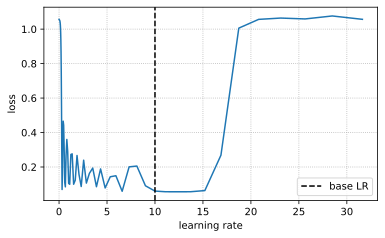

In [19]:
plt.figure(figsize=(6, 3.5))
plt.plot(lrs.detach(), losses)
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid(linestyle='dotted')
plt.axvline(10.0, color='k', linestyle='dashed', label='base LR')
plt.legend();

Notice that sampling is biased towards small learning rates. This makes sense since large learning rates tend to diverge. The graph is not representative for practical problems since the network is small and the loss surface is relatively simple. But following the algorithm, `lr=10.0` is chosen as the base learning rate for this task.

<br>

**LR scheduling.** Learning rate has to be decayed to later help with convergence. 
The following modifies the training script to include a simple schedule. Repeating the same experiment above for RMSProp and GD which had issues with oscillation:

In [20]:
def train_curve(
    optim, 
    optim_params: dict, 
    w_init=[5.0, 5.0], 
    loss_fn=pathological_loss, 
    num_steps=100
):
    
    w = torch.FloatTensor(w_init)
    w = nn.Parameter(w, requires_grad=True)
    optim = optim([w], **optim_params)
    points = [torch.tensor([w[0], w[1], loss_fn(w[0], w[1])])]
    
    for step in range(num_steps):
        optim.zero_grad()
        loss = loss_fn(w[0], w[1])
        loss.backward()
        optim.step()

        # logging
        p = w.data.detach()
        z = loss.unsqueeze(dim=0).detach()
        points.append(torch.cat([p, z]))

        # LR schedule (!)
        if step % 100 == 0:
            optim.lr *= 0.5

    return torch.stack(points, dim=0).numpy()

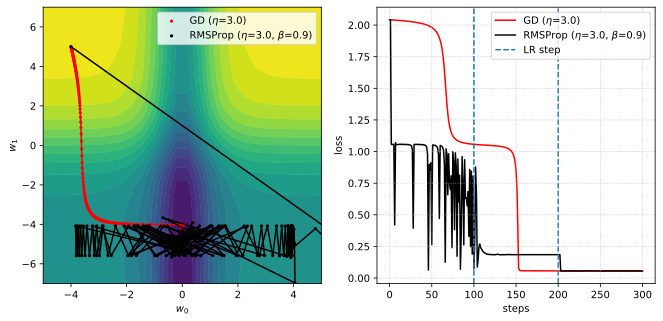

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plot_gd_steps(ax, optim=GD,      optim_params={"lr": 3.0},              w_init=[-4.0, 5.0], label_map=label_map_gdm,     color="red")
plot_gd_steps(ax, optim=RMSProp, optim_params={"lr": 3.0, "beta": 0.9}, w_init=[-4.0, 5.0], label_map=label_map_rmsprop, color="black")

ax[0].set_xlim(-5, 5)
ax[0].set_ylim(-7, 7)
ax[1].set_xlabel("steps")
ax[1].set_ylabel("loss")
ax[1].axvline(100, linestyle='dashed')
ax[1].axvline(200, linestyle='dashed', label='LR step', zorder=1)
ax[1].grid(linestyle="dotted", alpha=0.8)
ax[0].legend()
ax[1].legend();

Learning rate decay decreases GD oscillation drastically. The schedule $\boldsymbol{\boldsymbol{\Theta}}^{t+1} = \boldsymbol{\boldsymbol{\Theta}}^{t} - \eta \frac{1}{\alpha^t} \, \boldsymbol{\mathsf{m}}^{t}$ where $\alpha^t = 2^{\lfloor t / 100 \rfloor}$ is known as **step LR decay**. Note that this augments the second-moment for RMSProp which already auto-tunes the learning rate. Here we are able to start with a large learning rate allowing the optimizer to escape the first plateau earlier than before. Note that decay only decreases learning rate which can cause slow convergence. Some schedules implement **warm restarts** to fix this ({numref}`02-sgd-warm-restarts`).

**Remark.** For more examples of learning rate decay schedules [see here](https://d2l.ai/chapter_optimization/lr-scheduler.html#schedulers)  (e.g. **warmup** which initially gradually increases learning rate
since SGD at initialization can be unstable with large LR). Also see [PyTorch docs](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) on LR schedulers implemented in the library. For example, the schedule **reduce LR on plateau** which reduces the learning rate when a metric has stopped improving is implemented in PyTorch as `ReduceLROnPlateau` in the `torch.optim.lr_scheduler` library.

```python
# Example: PyTorch code for chaining LR schedulers
optim = SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler1 = ExponentialLR(optim, gamma=0.9)
scheduler2 = MultiStepLR(optim, milestones=[30,80], gamma=0.1)

for epoch in range(10):
    for x, y in dataset:
        optim.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        optim.step()
    
    # LR step called after optimizer update! ⚠⚠⚠
    scheduler1.step()
    scheduler2.step()
```

<br>

```{figure} ../../img/nn/02-sgd-warm-restarts.png
---
name: 02-sgd-warm-restarts
width: 60%
---
Cosine annealing starts with a large learning rate that is relatively rapidly decreased to a minimum value before being increased rapidly again. This resetting acts like a simulated restart of the model training and the re-use of good weights as the starting point of the restart is referred to as a "warm restart" in contrast to a "cold restart" at initialization. Source: {cite}`sgd-warm-restarts`
```

```{figure} ../../img/nn/02-snapshot-ensembles.png
---
name: 02-snapshot-ensembles
width: 80%
---
Effect of cyclical learning rates. Each model checkpoint for each LR warm restart (which often correspond to a minimum) can be used to create an ensemble model. Source: {cite}`snapshot-ensembles`
```

### Momentum

Good starting values for SGD momentum are $\beta = 0.9$ or $0.99$. Adam is easier to use out of the box where we like to keep the default parameters. If we have resources, and we want to push test performance, we can
tune SGD which is known to generalize better than Adam with more epochs. See {cite}`sgd_better_than_adam` where it is shown that Adam is more stable at sharp minima which tend to generalize worse than flat ones ({numref}`02-sharp-optim`).

```{figure} ../../img/nn/02-sharp-optim.png
---
name: 02-sharp-optim
width: 80%
---
A conceptual sketch of flat and sharp minima. The Y-axis indicates value of the loss
function and the X-axis the variables. Source: {cite}`sharp_minima_bad`
```

**Remark.** In principle, optimization hyperparameters affect training 
and not generalization. But the situation is more complex with SGD, where stochasticity
contributes to regularization. This was shown above where choice of batch size influences
the 
generalization gap. Also
recall that for batch GD (i.e. $B = N$ in SGD), consecutive gradients approaching a minimum 
roughly have the same direction. 
This should not happen with SGD with $B \ll N$ in the learning regime as different samples 
will capture different aspects of the loss surface.
Otherwise, the network is starting to overfit. Hence, optimization hyperparameters 
are tuned on the validation set as well in practice.

---

■